In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import utide
from sklearn.linear_model import LinearRegression
from collections import namedtuple
from matplotlib import dates as mdates
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from scipy.signal import argrelmax, argrelmin, find_peaks
import statsmodels.api as sm

import sys
sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

In [2]:
wdir = defs.ROOT / "data"

In [3]:
freq = "30 min"
data = pd.read_csv(wdir / "raw" / "mongla_tides.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=freq, name="datetime")).interpolate(method="time", limit=1, limit_direction="both")
data = data.loc["1998":]

In [4]:
lat = 22.4833
start = "1998"
end = "2010"
elev = data.loc[start:end].elevation
time = mdates.date2num((data.loc[start:end].index - pd.Timedelta("6 hours")).to_pydatetime())

In [5]:
coef_nodal = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=False, nodal=True, constit="auto")
coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=False, nodal=False, constit=list(coef_nodal.name))

tide = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef)
tide_nodal = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef_nodal)
tide_df = pd.DataFrame(data={"tide": tide.h,"tide_n": tide_nodal.h}, index=data.index)

solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
prep/calcs ... done.


In [6]:
def solve_const(index, coef, coef_nodal, constit):
    t = mdates.date2num((index - pd.Timedelta("6 hours")).to_pydatetime())
    tide = utide.reconstruct(t=t, coef=coef, constit=constit)
    tide_nodal = utide.reconstruct(t=t, coef=coef_nodal, constit=constit)
    df = pd.DataFrame(data={constit: tide.h, constit + "_n": tide_nodal.h}, index=index)
    return(df)

In [7]:
dfs = Parallel(n_jobs=-1)(delayed(solve_const)(index=data.index, coef=coef, coef_nodal=coef_nodal, constit=constit) for constit in coef.name)

In [13]:
tides = tide_df.join(other=data.elevation.rename("obs"))

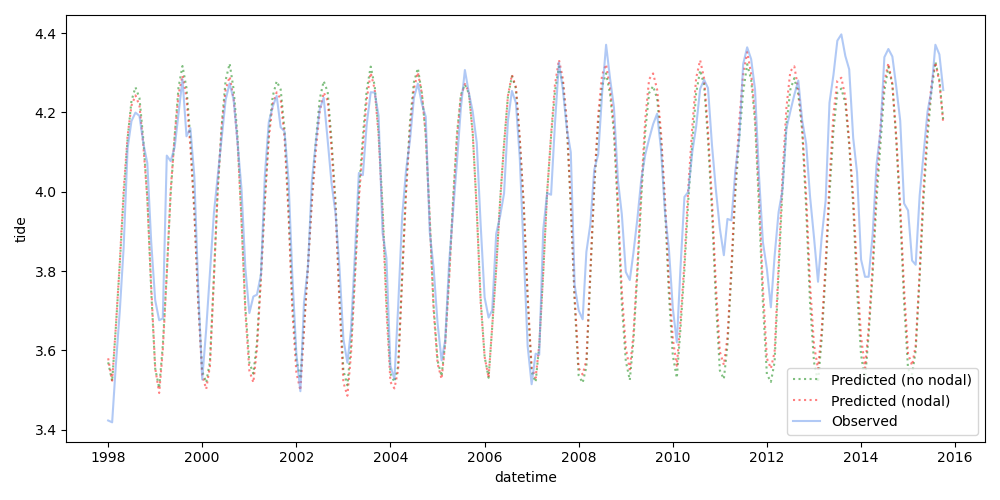

In [14]:
pdata = tides.groupby(by=pd.Grouper(freq="1D")).max().groupby(by=pd.Grouper(freq="1MS")).agg("mean").reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="tide", color="green", linestyle="dotted", alpha=0.5, ax=ax, label="Predicted (no nodal)")
sns.lineplot(data=pdata, x="datetime", y="tide_n", color="red", linestyle="dotted", alpha=0.5, ax=ax, label="Predicted (nodal)")
sns.lineplot(data=pdata, x="datetime", y="obs", color="cornflowerblue", alpha=0.5, ax=ax, label="Observed")

fig.tight_layout()

In [17]:
def lm_tides(data, ref_date=None, time_unit="365.25 days"):
    from collections import namedtuple

    if ref_date == None:
        ref_date = data.index[0]

    LM = namedtuple("LM", "coef, intercept , lin_ts, ts")

    x = ((data.index - ref_date) / pd.Timedelta(time_unit)).values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)

    lin_ts = pd.Series(data=lm.predict(x[[0, -1]]).flatten(), index=data.iloc[[0, -1]].index)

    return(LM(lm.coef_[0,0], lm.intercept_[0], lin_ts, data))

In [119]:
def plot_lm(lm):
    scatter_kwargs = {}
    line_kwargs = {}
    name = lm.ts.name
    if "MHW" in name:
        scatter_kwargs.update({"color": "green"})
        line_kwargs.update({"color": "green"})
    elif "MLW" in name:
        scatter_kwargs.update({"color": "red"})
        line_kwargs.update({"color": "red"})

    if "tide_n" in name:
        scatter_kwargs.update({"marker": "x", "s": 15})
        line_kwargs.update({"linestyle": "dotted"})
    elif "tide" in name:
        scatter_kwargs.update({"marker": "+", "s": 15})
        line_kwargs.update({"linestyle": "dashed"})
    elif "obs" in name:
        scatter_kwargs.update({"marker": "o", "s": 15})
        line_kwargs.update({"linestyle": "solid"})
    elif "obs_wo_node" in name:
        scatter_kwargs.update({"marker": ".", "s": 20})
        line_kwargs.update({"linestyle": ":"})

    sns.scatterplot(data=lm.ts, ax=ax, **scatter_kwargs)
    sns.lineplot(data=lm.lin_ts, ax=ax, **line_kwargs)

In [ ]:
daily = tides.groupby(by=pd.Grouper(freq="D")).agg(["max", "min"])
monthly = daily.groupby(by=pd.Grouper(freq="MS")).agg("mean").rename(columns={"max": "MHW", "min": "MLW"})

In [358]:
monthly["obs_wo_node", "MHW"] = (monthly.obs - (monthly.tide_n - monthly.tide)).MHW
monthly["obs_wo_node", "MLW"] = (monthly.obs - (monthly.tide_n - monthly.tide)).MLW

In [362]:
lms = monthly.loc["1998":"2010"].apply(func=lm_tides, result_type="reduce")

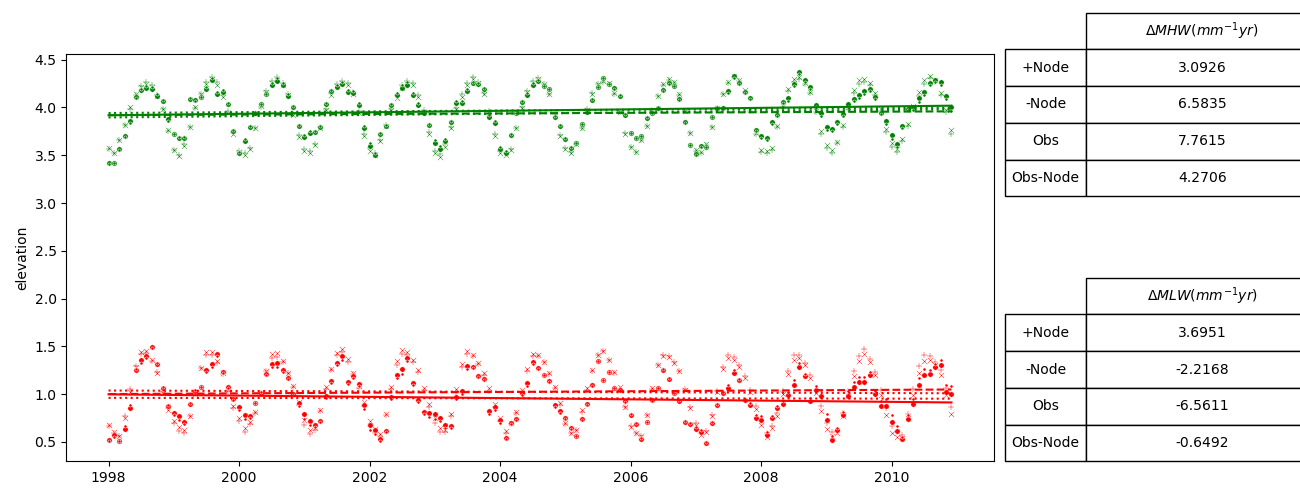

In [363]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

tbl_data = (lms.apply(lambda x: x.coef) * 1000).round(decimals=4).to_frame(name="coef").reset_index().rename(columns={"level_0": "node_type", "level_1": "data_type"})

for lm in lms:
    plot_lm(lm)

ax.table(cellText=tbl_data.loc[tbl_data.data_type == "MHW"].coef.values.reshape([-1, 1]),
        colLabels = ["$\Delta MHW (mm^{-1} yr)$"],
        rowLabels = ["+Node", "-Node", "Obs", "Obs-Node"],
        rowLoc = "center",
        cellLoc = "center",
        bbox = [1.1, 0.65, 0.25, 0.45])

ax.table(cellText=tbl_data.loc[tbl_data.data_type == "MLW"].coef.values.reshape([-1, 1]),
        colLabels = ["$\Delta MLW (mm^{-1} yr)$"],
        rowLabels = ["+Node", "-Node", "Obs", "Obs-Node"],
        rowLoc = "center",
        cellLoc = "center",
        bbox = [1.1, 0, 0.25, 0.45])

ax.set_ylabel("elevation")
ax.set_xlabel("")
fig.tight_layout()

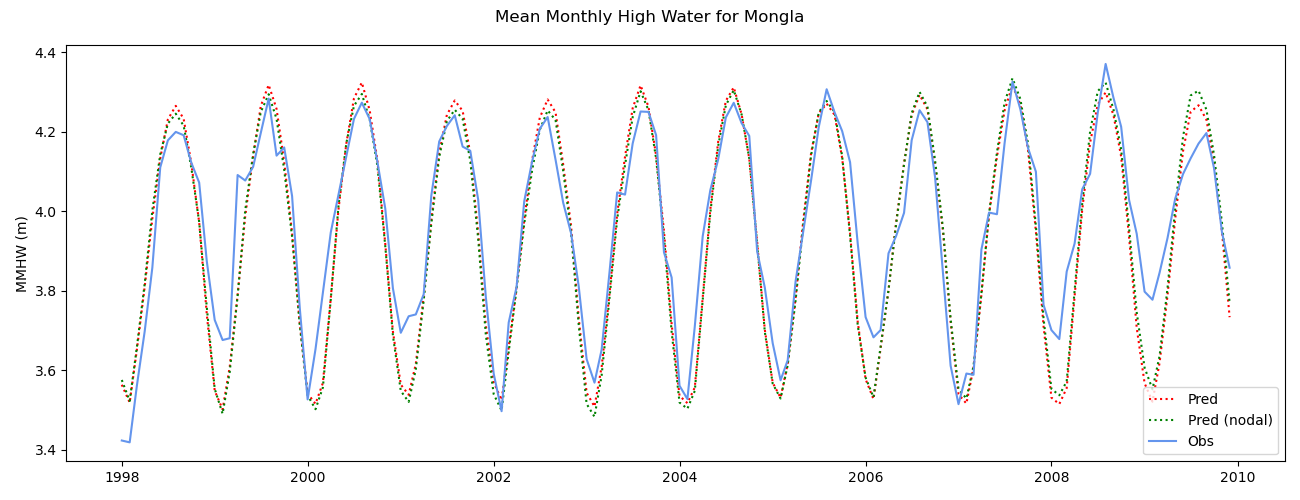

In [245]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

palette = ["red", "green"]

pdata = monthly.loc(axis=1)[:, "MHW"].loc["1998":"2009"]

sns.lineplot(data=pdata.tide.MHW, color="red", linestyle="dotted", label="Pred")
sns.lineplot(data=pdata.tide_n.MHW, color="green", linestyle="dotted", label="Pred (nodal)")
sns.lineplot(data=pdata.obs.MHW, color="cornflowerblue", label="Obs")


ax.set_ylabel("MMHW (m)")
ax.set_xlabel("")
fig.suptitle("Mean Monthly High Water for Mongla")
# ax.set_xlim(pd.Timestamp("1998"), pd.Timestamp("2005"))
fig.tight_layout()

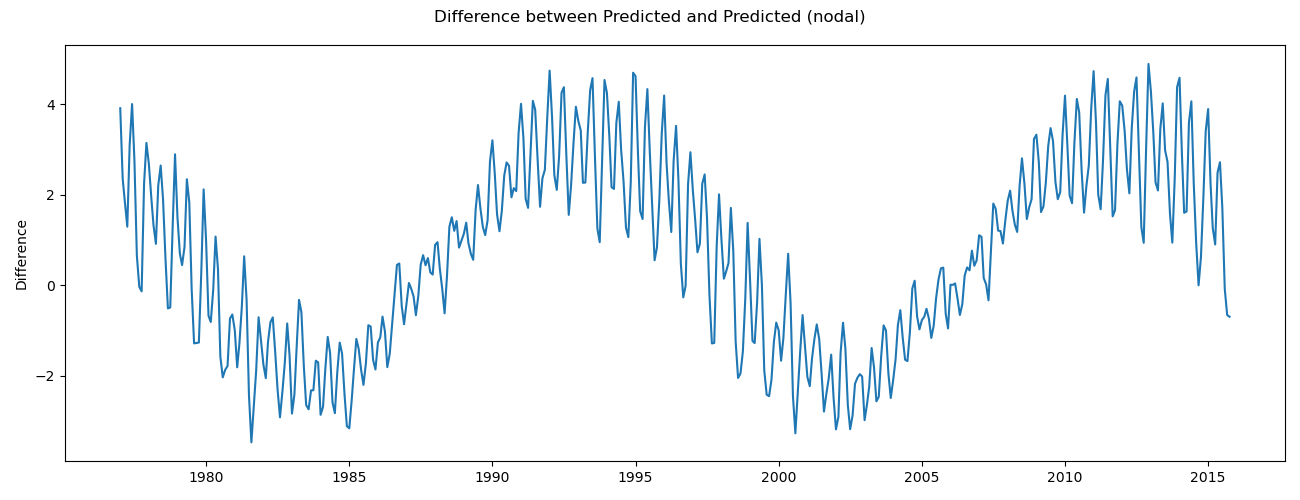

In [364]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.lineplot(data=(monthly.tide_n - monthly.tide).MHW * 100)

ax.set_ylabel("Difference")
fig.suptitle("Difference between Predicted and Predicted (nodal)")
ax.set_xlabel("")
fig.tight_layout()

In [258]:
freq = "30 min"
n_per_hour = pd.Timedelta("1 hour") / pd.Timedelta(freq)
data = pd.read_csv(wdir / "raw" / "mongla_tides.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=freq, name="datetime"))
data.elevation = data.elevation.interpolate(method="time", limit=1, limit_direction="both")
data["elapsed"] = data.index - data.index[0]
data = data[["elapsed", "elevation"]]

In [261]:
data[["high", "low"]] = False
distance = n_per_hour * 8
hi = find_peaks(x=data.elevation.values, distance=distance)[0]
lo = find_peaks(x=data.elevation.values * -1, distance=distance)[0]
data.loc[data.iloc[hi].index, "high"] = True
data.loc[data.iloc[lo].index, "low"] = True

In [263]:
dt = pd.Timedelta("30 days")
stds = 3
r_high = data.elevation.loc[data.high == True].rolling(window=dt, center=True)
top = r_high.mean() + stds * r_high.std()
bot = r_high.mean() -  stds * r_high.std()
highs_for_roll = data.loc[data.high == True].loc[data.loc[data.high == True].elevation.between(bot, top)].elevation

r_low = data.elevation.loc[data.low == True].rolling(window=dt, center=True)
top = r_low.mean() + stds * r_low.std()
bot = r_low.mean()  -  stds * r_low.std()
lows_for_roll = data.loc[data.low == True].loc[data.loc[data.low == True].elevation.between(bot, top)].elevation

In [264]:
data["high_roll"] = highs_for_roll.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["low_roll"] = lows_for_roll.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["amp_roll"] = data.high_roll - data.low_roll

In [268]:
window = pd.Timedelta("27 hour")
exog = (data.index - data.index[0]).total_seconds().astype(int)
frac = window / pd.Timedelta(freq) / len(data)
delta = window * 500 / pd.Timedelta(freq)
endogs = (data.high_roll.values, data.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, delta=delta, is_sorted=True) for endog in endogs)

In [269]:
data.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + data.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
data.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + data.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
data["amp_smooth"] = data.high_smooth - data.low_smooth

In [270]:
data[["spring", "neap"]] = False
distance = n_per_hour * 24 * 11 # search distance in hours
hi = find_peaks(x=data.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=data.amp_smooth.values * -1, distance=distance, height=-2.5)[0]
data.loc[data.iloc[hi].index, "spring"] = True
data.loc[data.iloc[lo].index, "neap"] = True

In [274]:
springs = data.loc[data.spring == True].apply(
    lambda x: pd.Series(data=(
        data.loc[data.high == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        data.loc[data.low == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

neaps = data.loc[data.neap == True].apply(
    lambda x: pd.Series(data=(
        data.loc[data.high == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        data.loc[data.low == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

In [292]:
(springs.loc["1998":"2009"].apply(lambda row: row.high - row.low, axis=1).mean() + neaps.loc["1998":"2009"].apply(lambda row: row.high - row.low, axis=1).mean()) / 2 * 0.037

0.10227863380369634

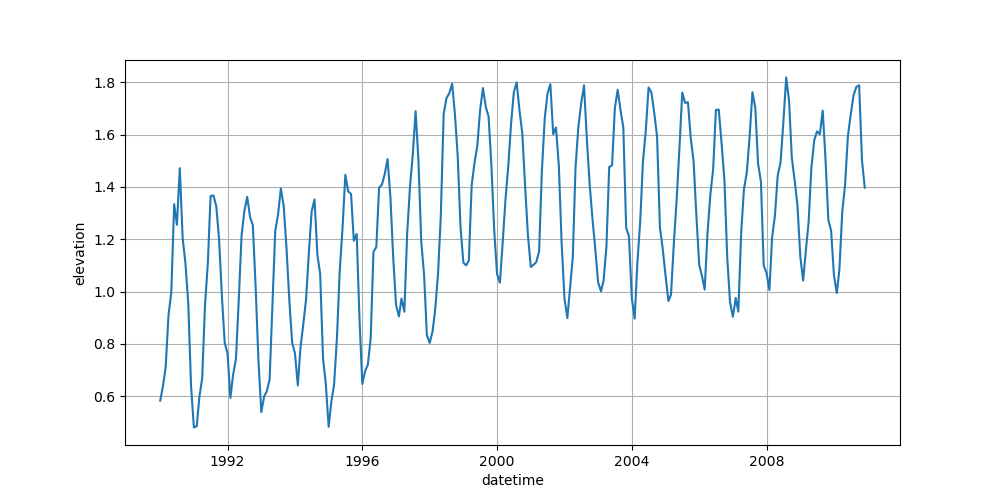

In [349]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=(data.loc["1990":"2010"].elevation - 1.175).groupby(pd.Grouper(freq="MS")).mean(), ax=ax)
ax.grid()

<AxesSubplot:xlabel='datetime', ylabel='elevation'>

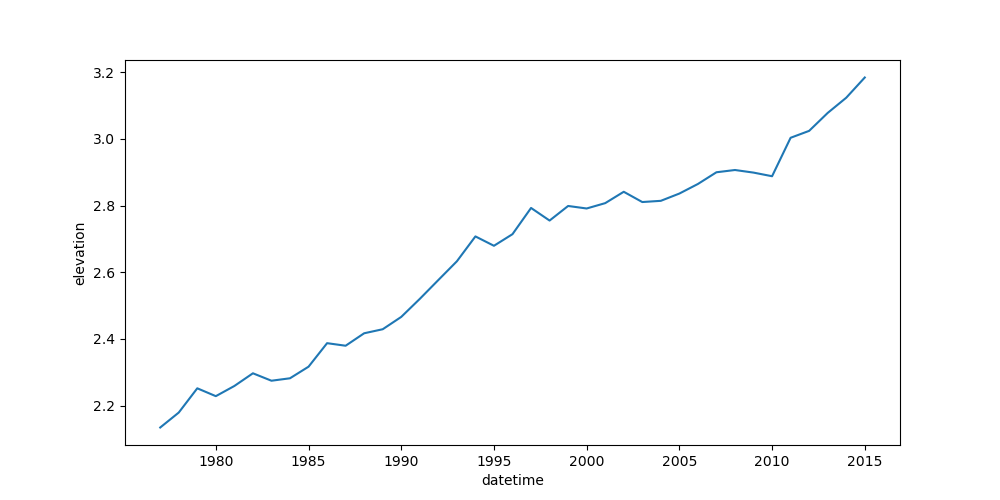

In [335]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

mtr = data.loc[data.high == True].groupby(pd.Grouper(freq="AS")).elevation.mean() - data.loc[data.low == True].groupby(pd.Grouper(freq="AS")).elevation.mean()

sns.lineplot(data=mtr, ax=ax)

<AxesSubplot:xlabel='datetime'>

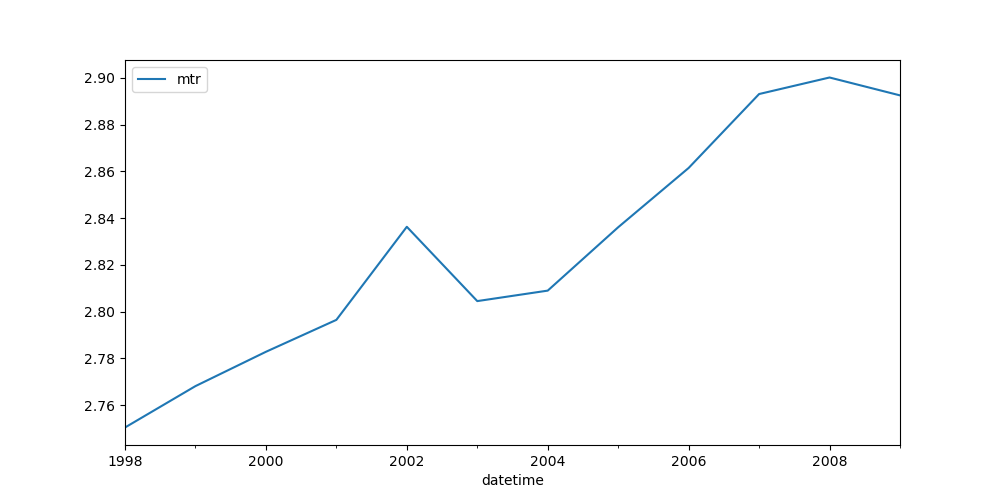

In [322]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

data.loc["1998":"2009"].amp_roll.groupby(pd.Grouper(freq="AS")).mean().to_frame("mtr").reset_index().plot(ax=ax, kind="line", x="datetime", y="mtr")

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

obs_wo_node = (monthly.observed - (monthly.w_nodal - monthly.wo_nodal)).melt(var_name="type", value_name="elevation", ignore_index=False)
obs_lm = obs_wo_node.groupby(by="type").apply(lambda x: lm_tides(x.elevation, data.index[0])["ts"]).T.melt(value_name="elevation", ignore_index=False)

palette = {'MHW': "green", 'MLW': "red"}

sns.lineplot(data=obs_wo_node.reset_index(), x="datetime", y="elevation", hue="type", palette=palette, ax=ax, alpha=0.3, zorder=15, legend=False)
sns.lineplot(data=obs_lm.reset_index(), x="datetime", y="elevation", hue="type", palette=palette, linestyle="dotted", ax=ax, zorder=1)

ax.text(x=obs_lm.index.mean(), y=obs_lm.loc[obs_lm.type == "MHW"].max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(monthly_lm.w_nodal.MHW.coef * 1000), fontsize="medium")
ax.text(x=obs_lm.index.mean(), y=monthly_lm.w_nodal.MLW.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(monthly_lm.w_nodal.MLW.coef * 1000), fontsize="medium")

fig.tight_layout()

In [ ]:
pdata = nodal.groupby(by=pd.Grouper(freq="1D")).max().groupby(by=pd.Grouper(freq="1MS")).agg("mean").reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

# sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.5, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="w", color="green", linestyle="dotted", alpha=0.5, ax=ax, label="w")
sns.lineplot(data=pdata, x="datetime", y="wo", color="red", linestyle="dotted", alpha=0.5, ax=ax, label="w/o")

fig.tight_layout()

In [ ]:
pdata

In [ ]:
pdata = nodal.groupby(by=pd.Grouper(freq="1D")).max().groupby(by=pd.Grouper(freq="1MS")).agg("mean").reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y=(pdata.w - pdata.wo) * 100, color="green", linestyle="dotted", alpha=0.5, ax=ax)

fig.tight_layout()

In [ ]:
pdata = nodal.groupby(by=pd.Grouper(freq="1D")).max().groupby(by=pd.Grouper(freq="1MS")).agg("mean").reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.5, ax=ax)
# sns.lineplot(data=pdata, x="datetime", y="w", color="green", linestyle="dashed", alpha=0.5, ax=ax, label="w")
sns.lineplot(data=pdata, x="datetime", y="wo", color="red", linestyle="dotted", alpha=0.5, ax=ax, label="w/o")

# sns.scatterplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", ax=ax)
# sns.scatterplot(data=pdata, x="datetime", y="w", color="green", ax=ax)
# sns.scatterplot(data=pdata, x="datetime", y="wo", color="red", ax=ax)

fig.tight_layout()

In [ ]:
pdata = nodal.groupby(by=pd.Grouper(freq="1D")).max().groupby(by=pd.Grouper(freq="1MS")).agg("mean").reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

# sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.5, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="w", color="green", linestyle="dashed", alpha=0.5, ax=ax, label="w")
sns.lineplot(data=pdata, x="datetime", y="wo", color="red", linestyle="dotted", alpha=0.5, ax=ax, label="w/o")

# sns.scatterplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", ax=ax)
# sns.scatterplot(data=pdata, x="datetime", y="w", color="green", ax=ax)
# sns.scatterplot(data=pdata, x="datetime", y="wo", color="red", ax=ax)

fig.tight_layout()

In [ ]:
start = pd.to_datetime("2014-07-01")
end = start + pd.Timedelta("30D")

pdata = nodal.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="w", color="green", linestyle="dotted", alpha=0.3, ax=ax, label="w")
sns.lineplot(data=pdata, x="datetime", y="wo", color="red", linestyle="dotted", alpha=0.3, ax=ax, label="w/o")


title = "Mongla Tidal Data from {} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
# ax.set_xlim(start, end)
fig.tight_layout()

In [ ]:
start = pd.to_datetime("2005-01-01")
end = start + pd.Timedelta("90D")

pdata = nodal.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="w_diff", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="wo_diff", color="red", alpha=0.3, ax=ax)


title = "Mongla Tidal Data from {} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
# ax.set_xlim(start, end)
fig.tight_layout()

In [ ]:
data["pred"] = tide.h

In [ ]:
start = pd.to_datetime("2003-05-01")
end = start + pd.Timedelta("90D")

pdata = data.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="pred", color="red", linestyle="dotted", alpha=0.3, ax=ax)

title = "Mongla Tidal Data from {} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
# ax.set_xlim(start, end)
fig.tight_layout()